In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import re
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections import Counter
from typing import List, Tuple
import pandas as pd
from transformers import OpenAIGPTTokenizer, AutoTokenizer, AutoModel
import pickle
plt.rcParams['figure.figsize'] = 10, 6

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2.1.1

In [46]:
file_path = r'../gutenberg-poetry-dataset2.csv'
batch_size = 128
shuffle = True
sequence_length = 100  # for example, predicting 10th word based on previous 9 words
sequence_length_enc = 25

# dataset = BeowulfDataset(file_path, sequence_length, sequence_length_enc)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Example usage:
# print(f"Number of unique tokens in the dataset: {dataset.num_unique_tokens()}")

# print(dataset[128])
# uniques = dataset.num_unique_tokens()
# print(uniques)



In [47]:
text = pandas.read_csv(file_path)
text = text[["title", "content"]]
text = text.dropna()

In [82]:
def remove_volume(text):
    pattern = r'— volume \d+'
    cleaned_text = re.sub(pattern, '', text)

    pattern = r'.? vol. \d+'
    cleaned_text = re.sub(pattern, '', cleaned_text)

    pattern = r',? vol. \d+'
    cleaned_text = re.sub(pattern, '', cleaned_text)

    pattern = r',? volume \d+'
    cleaned_text = re.sub(pattern, '', cleaned_text)

    return cleaned_text

def remove_after_tab(text):
    return text.split('\t')[0]

def to_lower(text):
    return text.lower()

def remove_part(text):
    pattern = r'— part \d+'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

# pipeline
def data_pipeline(transformations):

    def pipeline(text):
        output = text[:]
        for transformation in transformations:
            output = transformation(output)
    
        return output

    return pipeline

def remove_version(text):
    pattern =  r',? version \d+(\.\d+)+'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

# Funkcja do usuwania ", 24 jul 1996"
def remove_date(text):
    pattern = r',? [a-zA-Z]+ \d{1,2},? \d{4}'
    cleaned_text = re.sub(pattern, '', text)

    pattern = r',? \d{4}'
    cleaned_text = re.sub(pattern, '', cleaned_text)
    
    return cleaned_text

def remove_after_last_comma(text):
    return ','.join(text.split(',')[:-1])



transformations = [to_lower,
                  remove_volume,
                  remove_after_tab,
                  remove_part,
                  remove_version,
                  remove_date,
                  # remove_after_last_comma
                  ]

pipeline = data_pipeline(transformations)

new_titles = text['title'].apply(pipeline)


for i in range(len(new_titles)):
    print(f'{i}: {new_titles.iloc[i]}')

0: paradise lost
1: aesop's fables
2: far from the madding crowd
3: the communist manifesto
4: violists
5: the mayor of casterbridge
6: the island of doctor moreau
7: charlotte temple
8: child christopher and goldilind the fair
9: clotelle; or, the colored heroine, a tale of the southern states; or, the president's daughter
10: my antonia
11: ballads of a cheechako
12: a dome of many-coloured glass
13: trees and other poems
14: records of a family of engineers
15: the golden age
16: beauty and the beast, and tales of home
17: paul prescott's charge
18: the early short fiction of edith wharton 
19: the cash boy
20: the flirt
21: the market-place
22: ballad of reading gaol
23: indian boyhood
24: the soul of the indian
25: dracula
26: hesiod, the homeric hymns, and homerica
27: the harvester
28: of human bondage
29: in flanders fields and other poems
30: good stories for holidays
31: the mad king
32: the lost prince
33: the great god pan
34: tales and fantasies
35: the great war syndicate

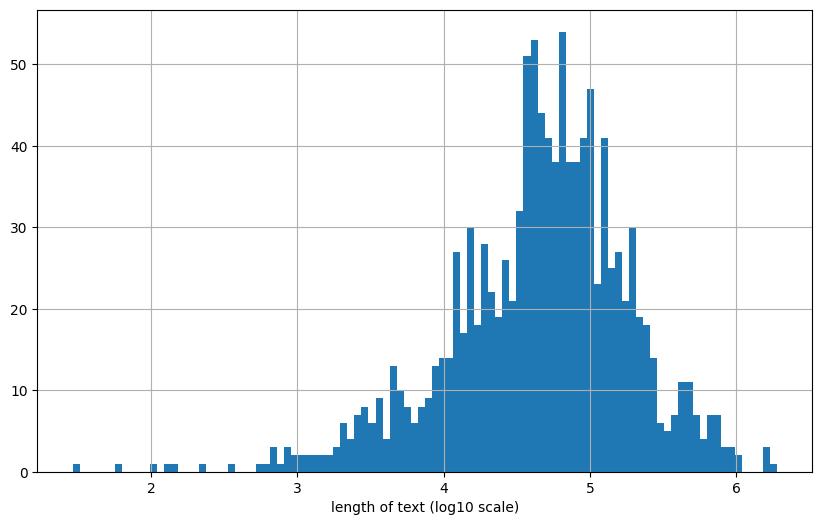

In [95]:
text['content'].apply(lambda x: np.log10(len(x))).hist(bins=100)
plt.xlabel('length of text (log10 scale)')
plt.show()